# Exploratory Data Analysis
Exploring distributions of each feature and running preliminary confirmatory factor analysis 

### Imports & Directories

In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import ConfirmatoryFactorAnalyzer, ModelSpecificationParser
from scipy.stats import norm

In [2]:
current_dir = os.getcwd()
project_root = os.path.dirname(os.path.dirname(current_dir))
PROCESSED_DATA_PATH = os.path.join(project_root, 'data', 'processed')
RAW_DATA_PATH = os.path.join(project_root, 'data', 'raw')
OUTPUT_PATH = os.path.join(project_root, 'output')

### Map codes for human readable features 

In [3]:
# Load the JSON file containing the shorter descriptions
with open(PROCESSED_DATA_PATH + '/codes.json', 'r') as f:
    codes = json.load(f)

# Create a mapping of original codes to descriptive names
code_to_name = {item['original_code']: item['descriptive_name'] for item in codes}

data = pd.read_excel(RAW_DATA_PATH + '/HPM data_environmental performance.xlsx')

# Rename columns using the shorter descriptions
data.rename(columns=code_to_name, inplace=True)

### Visualise distribution of each feature

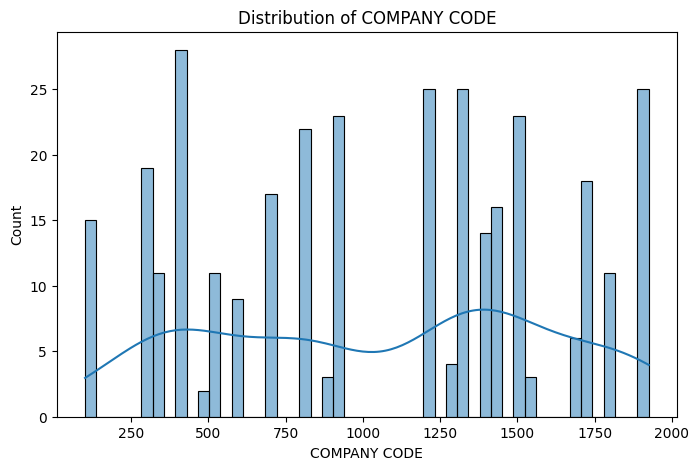

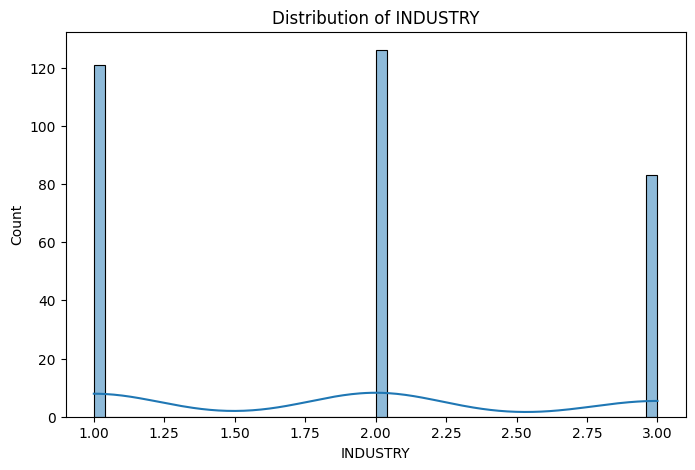

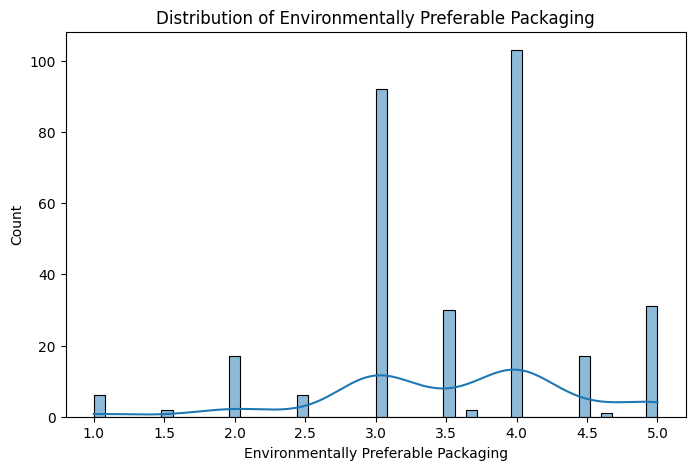

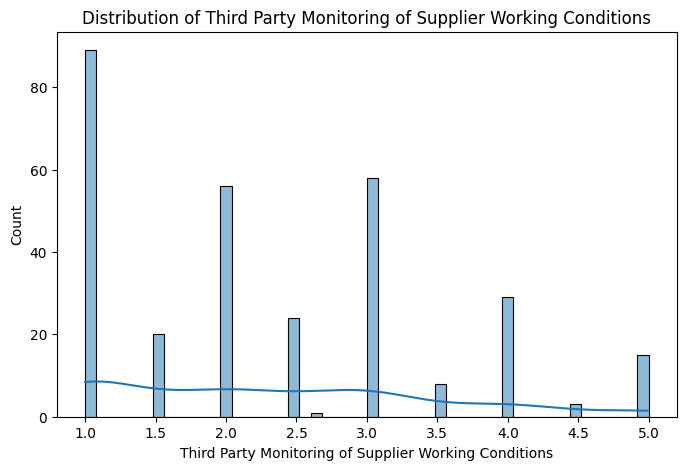

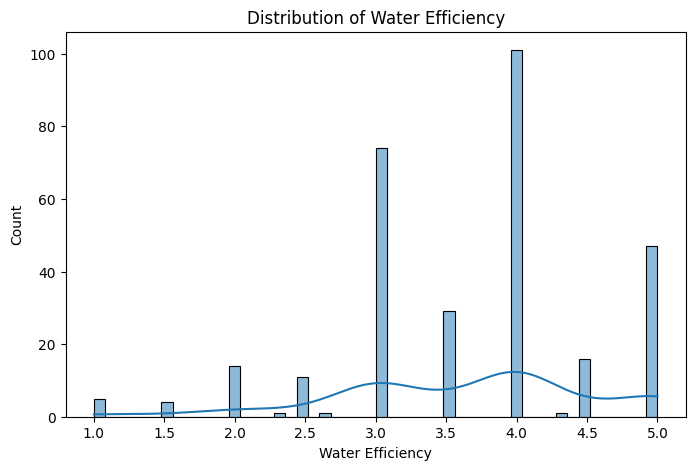

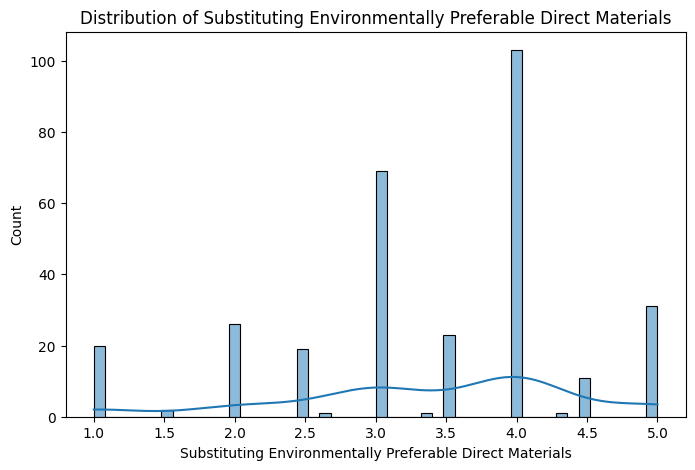

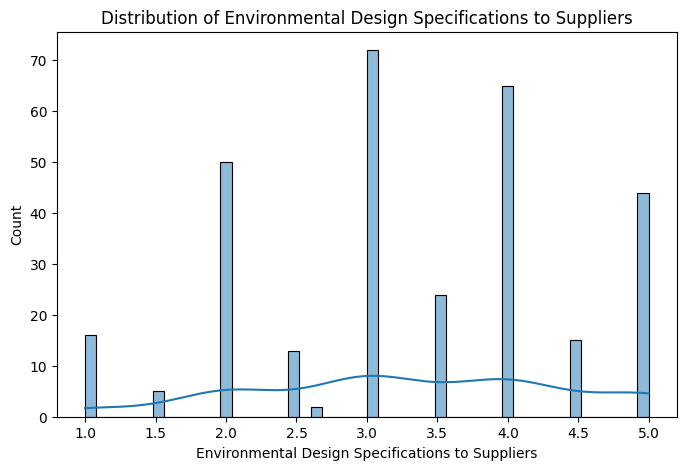

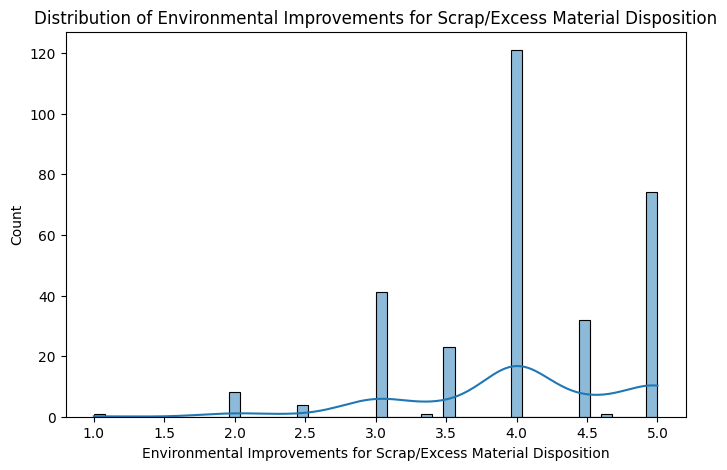

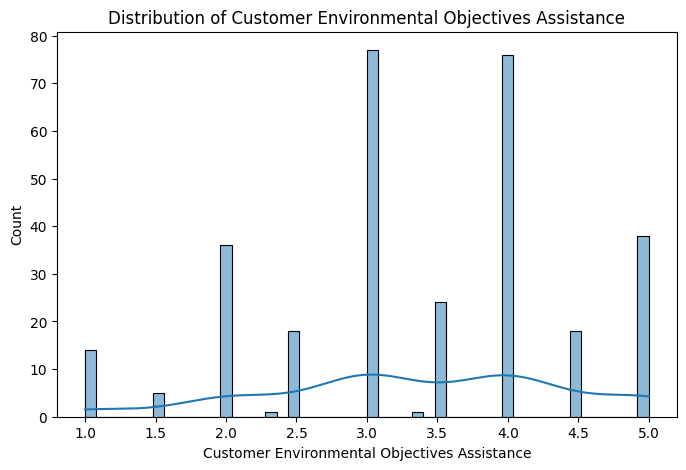

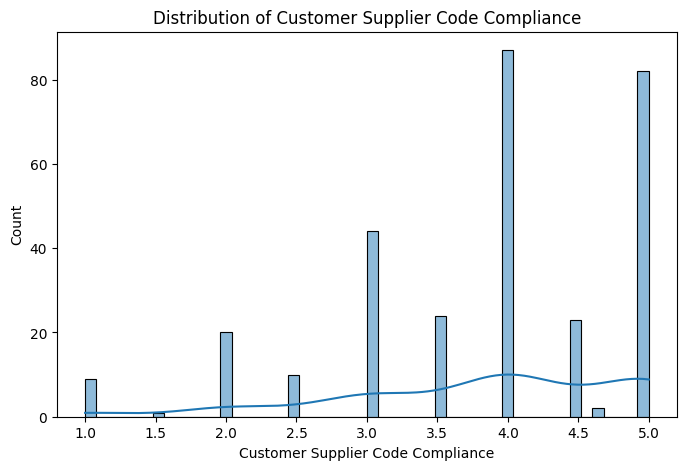

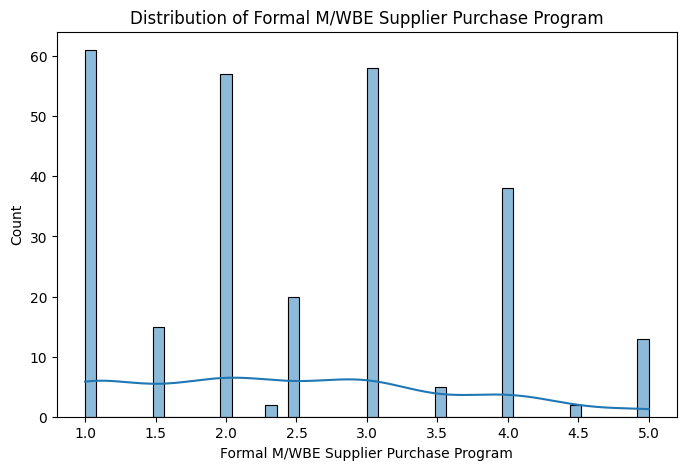

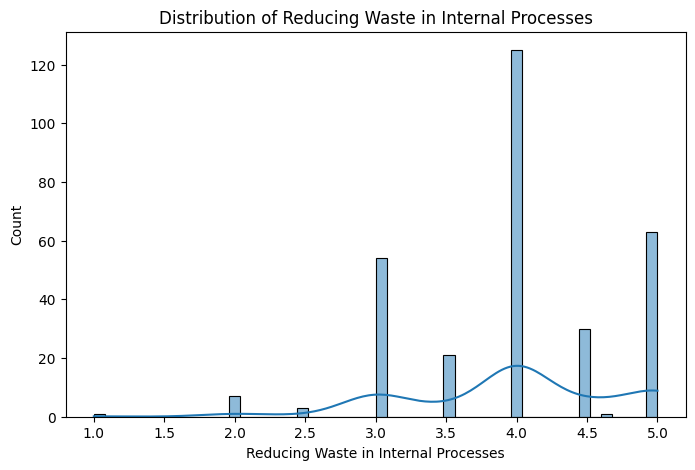

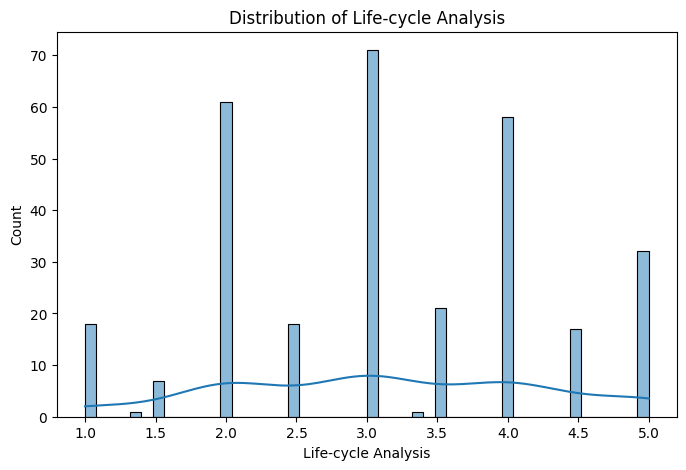

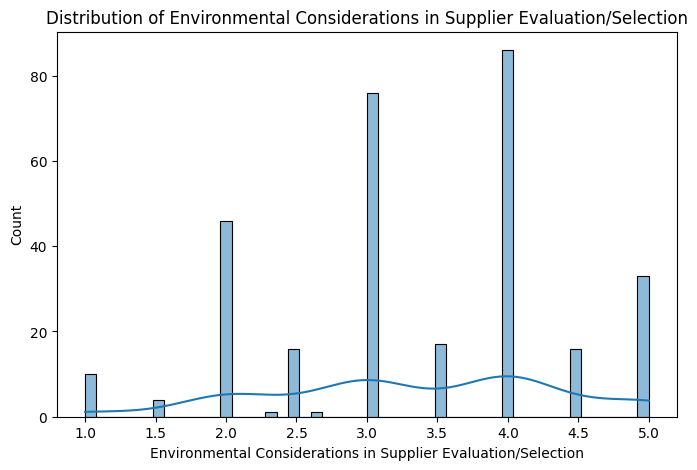

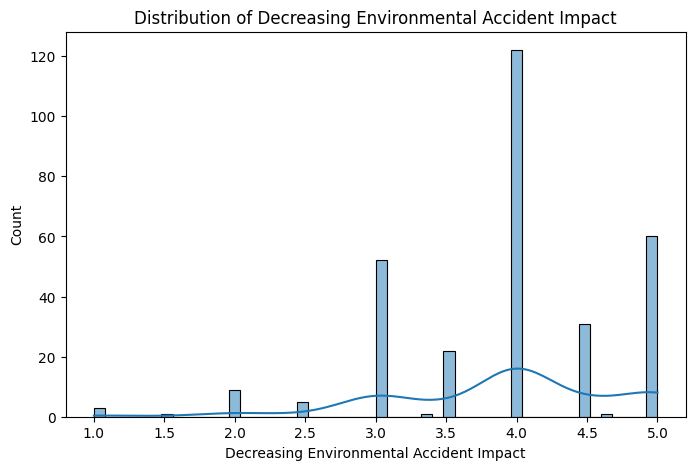

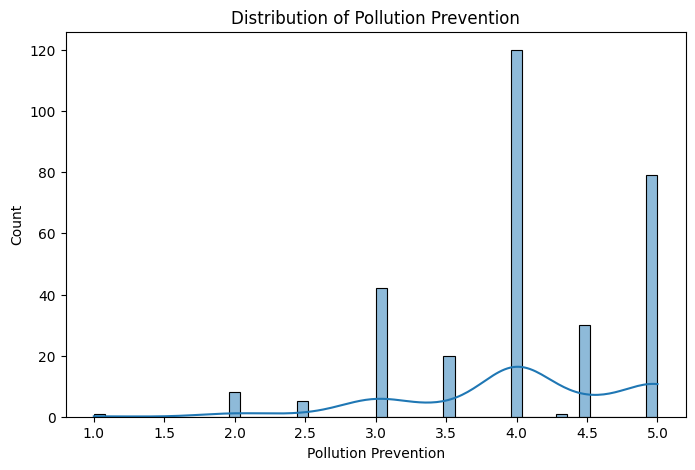

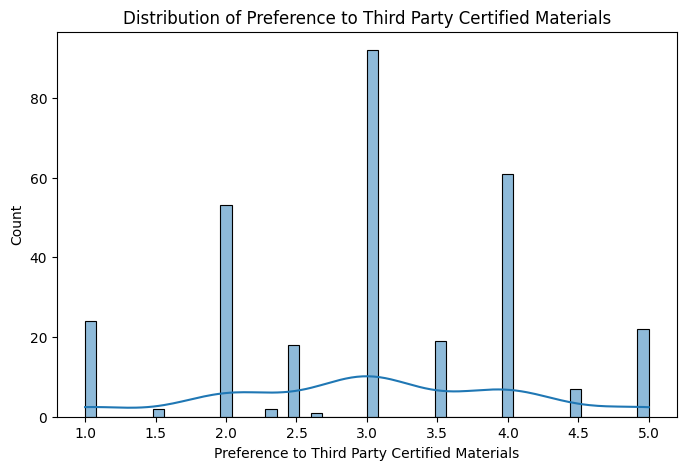

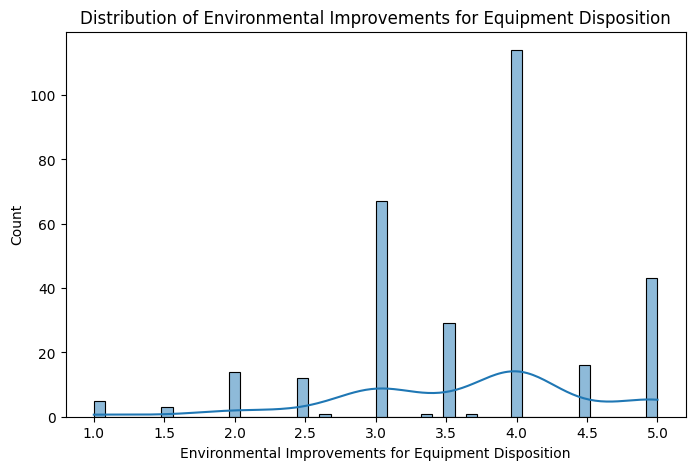

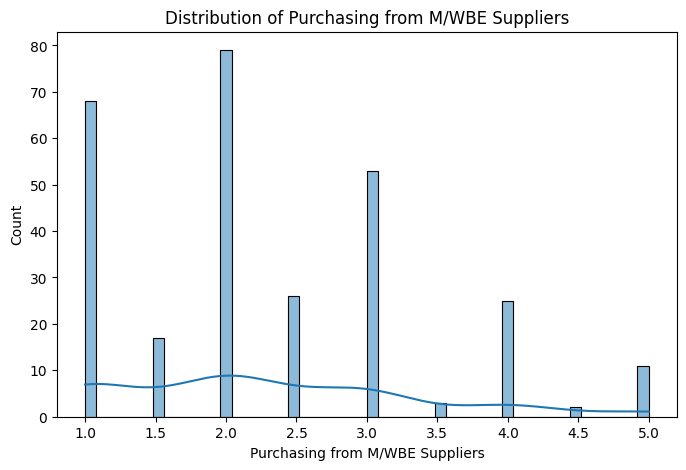

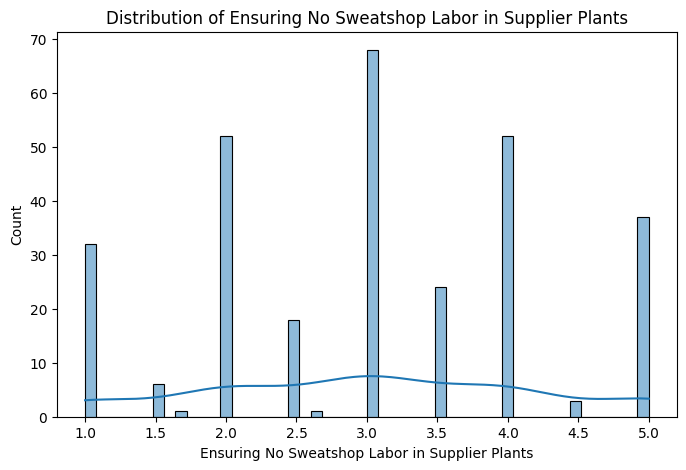

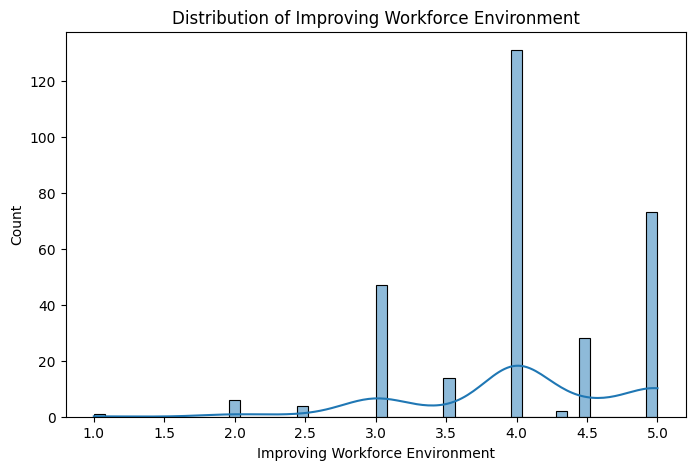

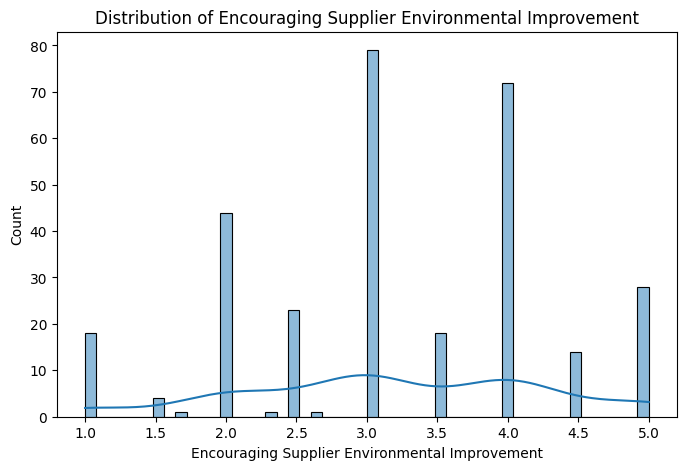

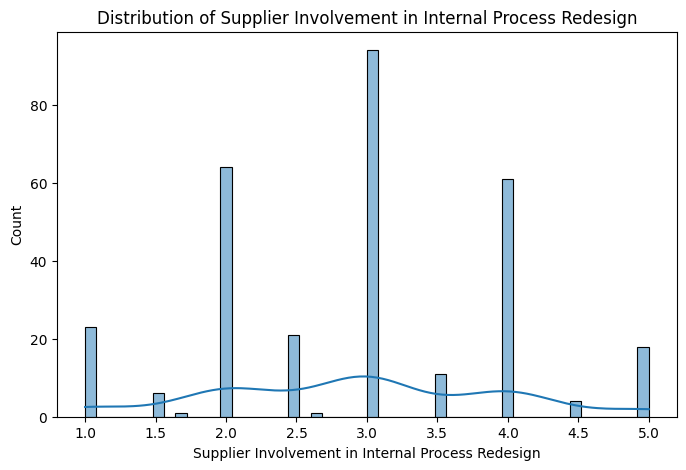

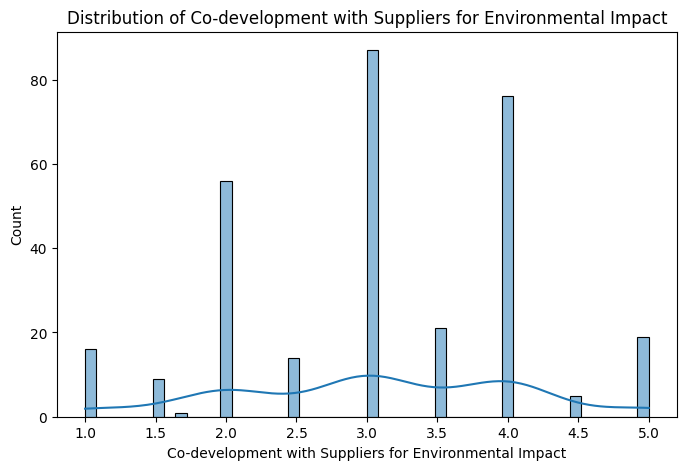

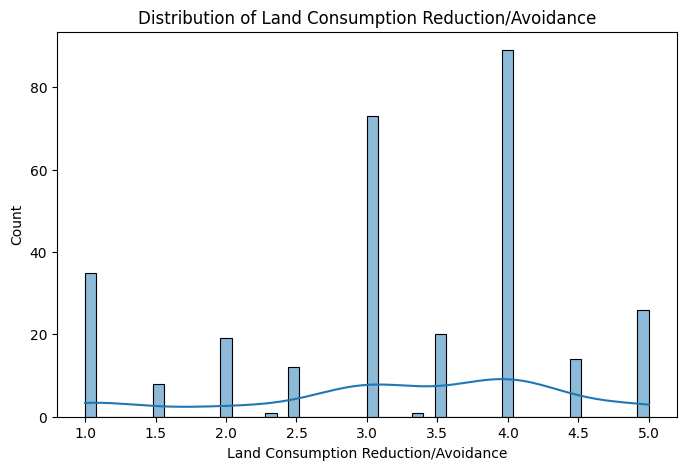

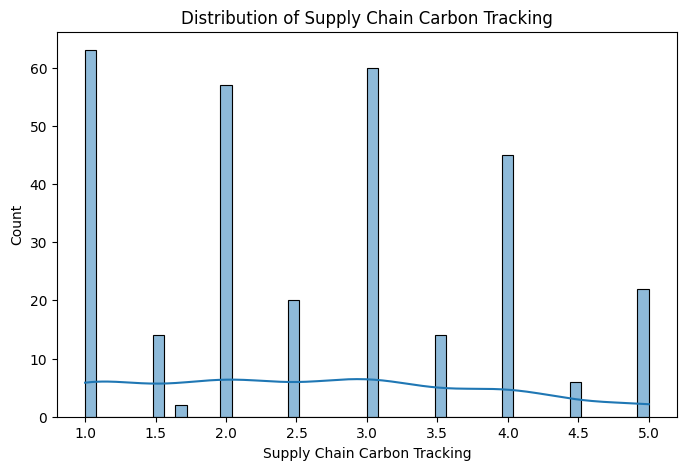

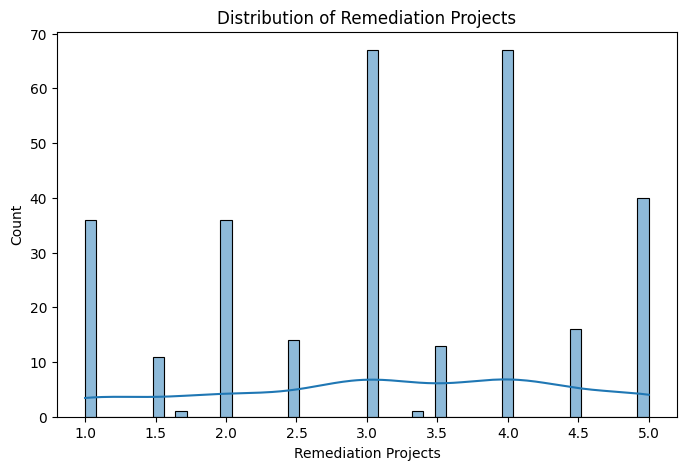

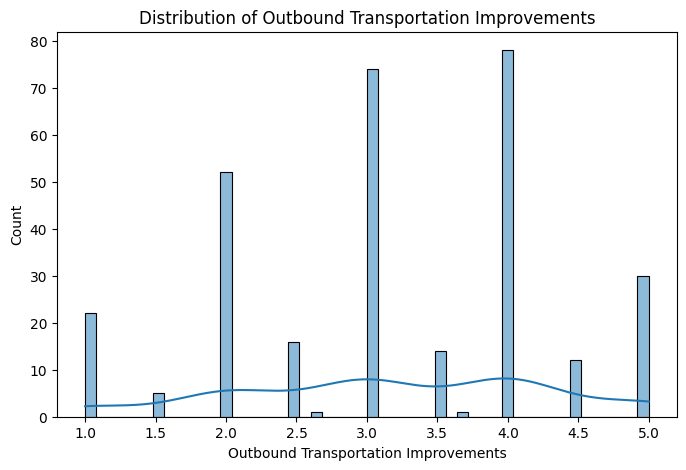

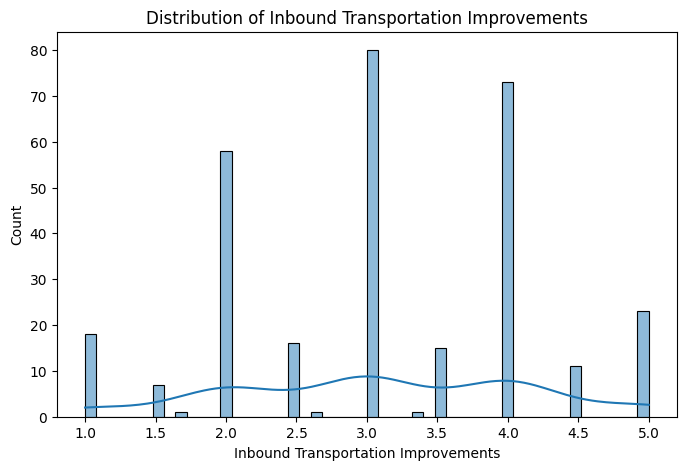

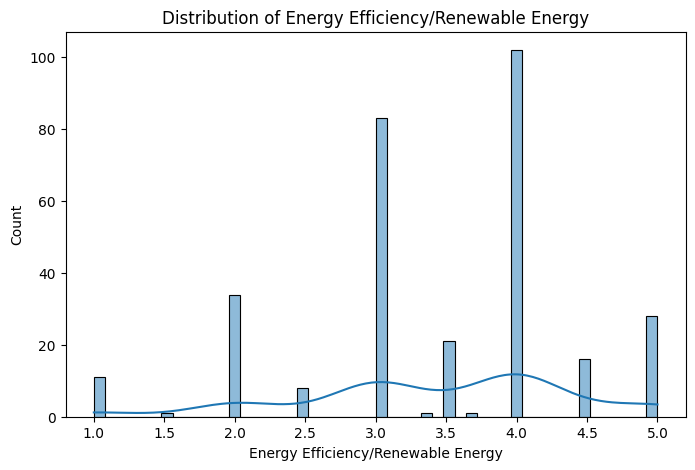

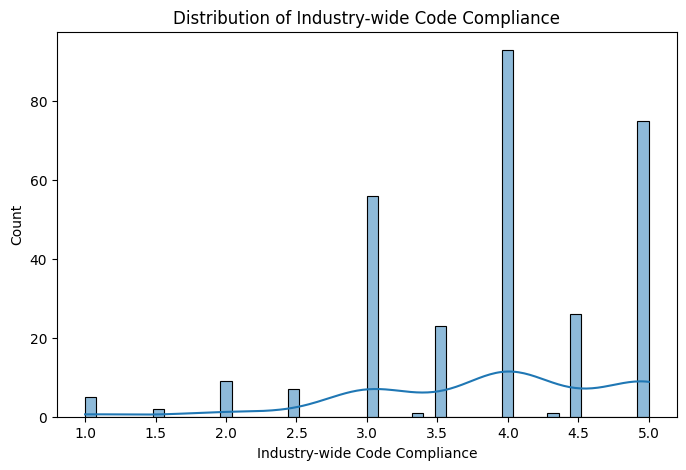

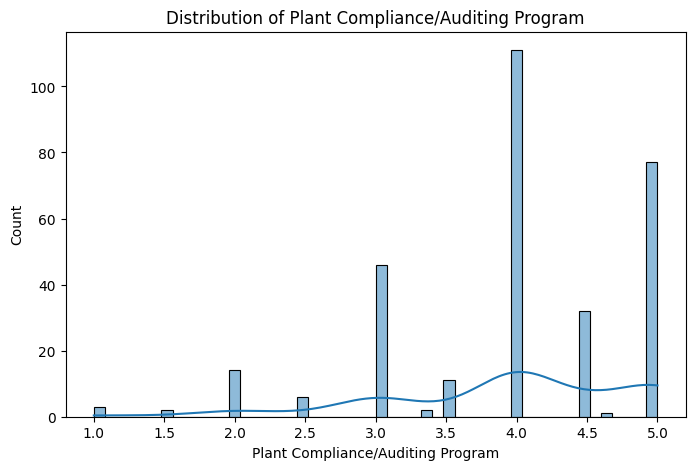

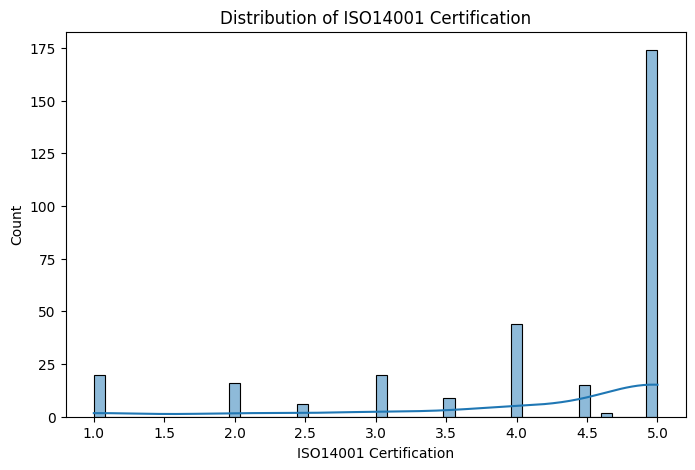

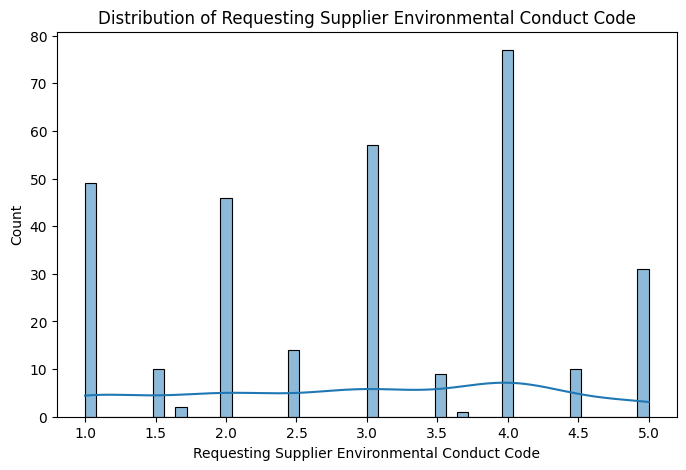

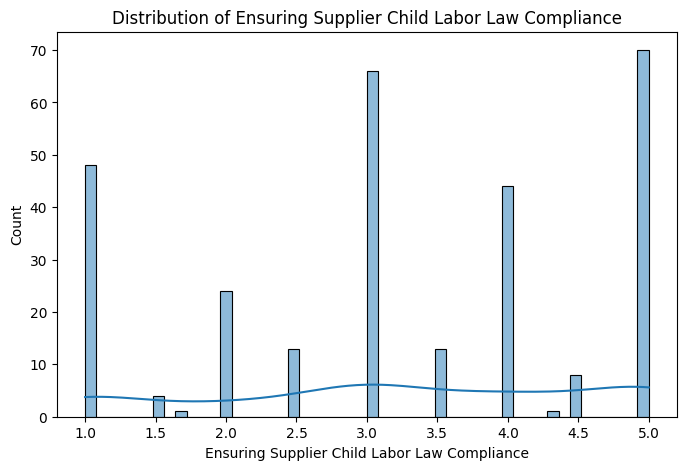

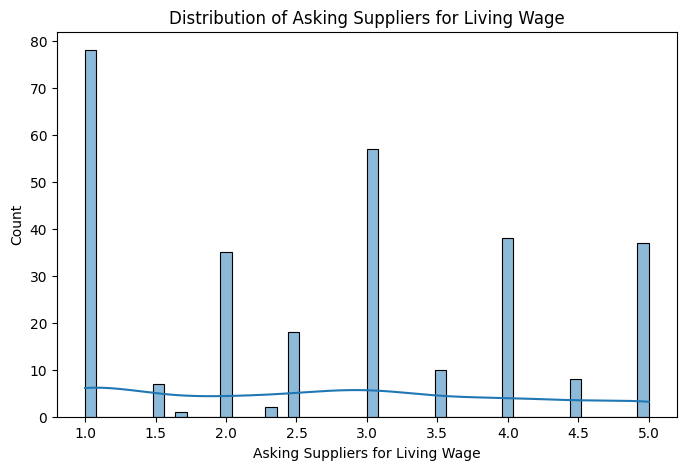

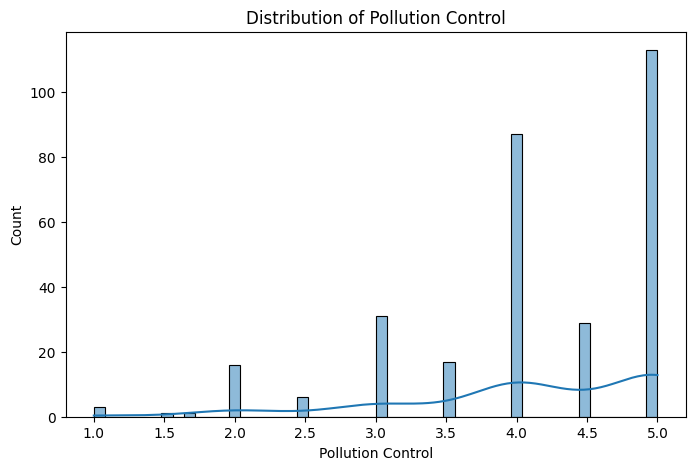

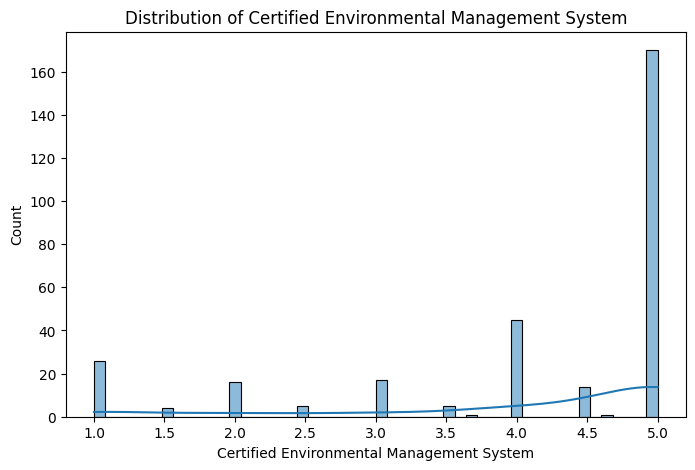

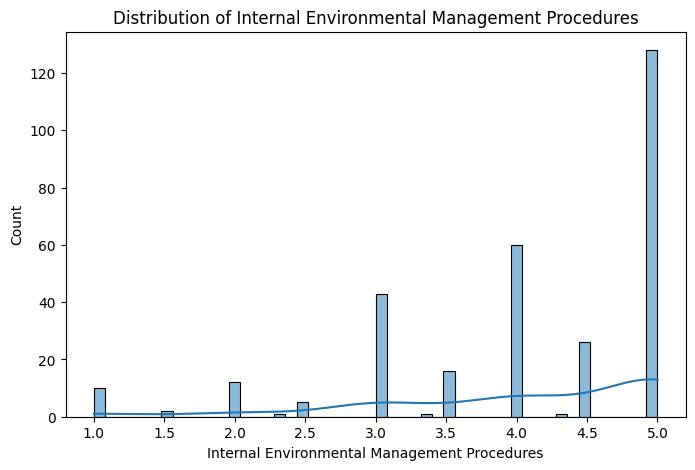

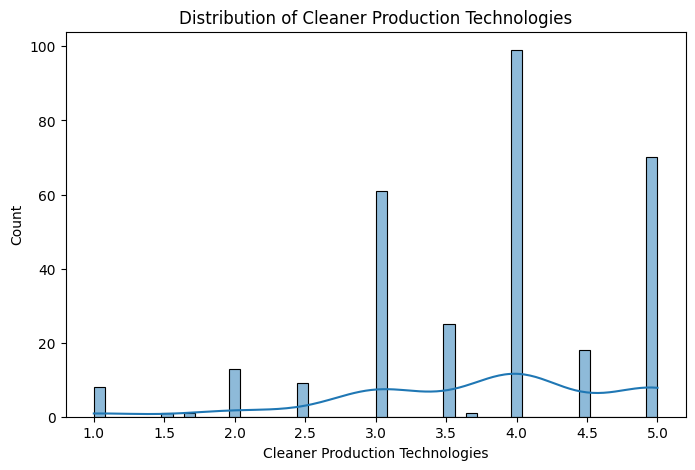

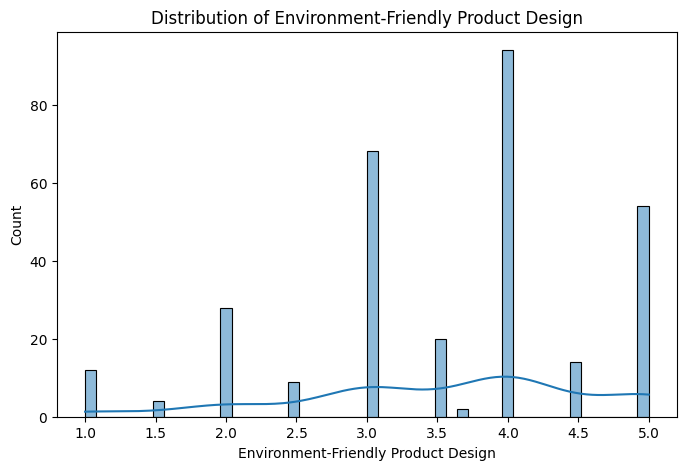

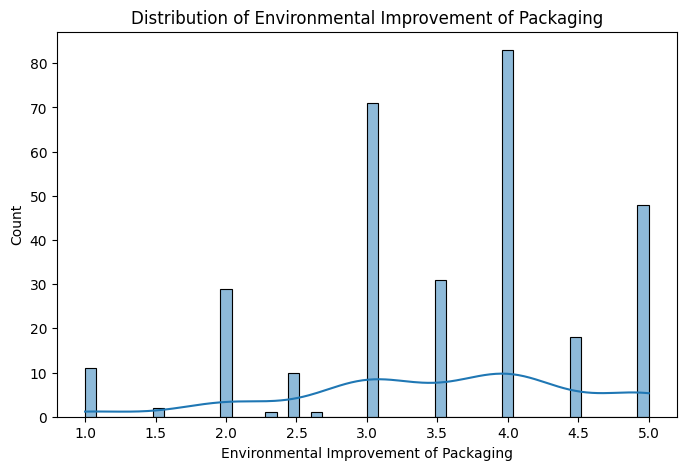

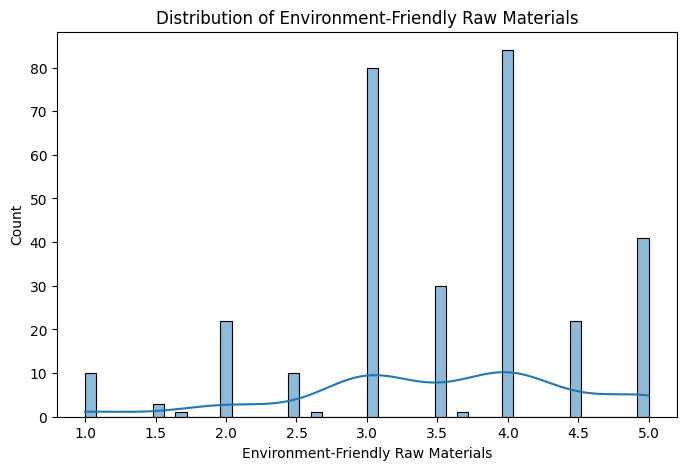

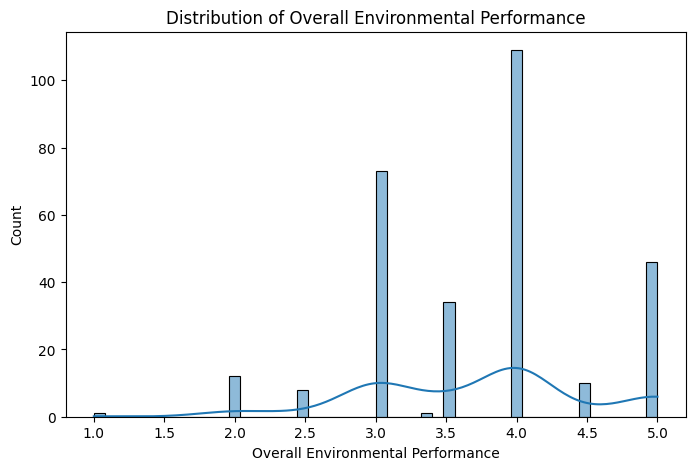

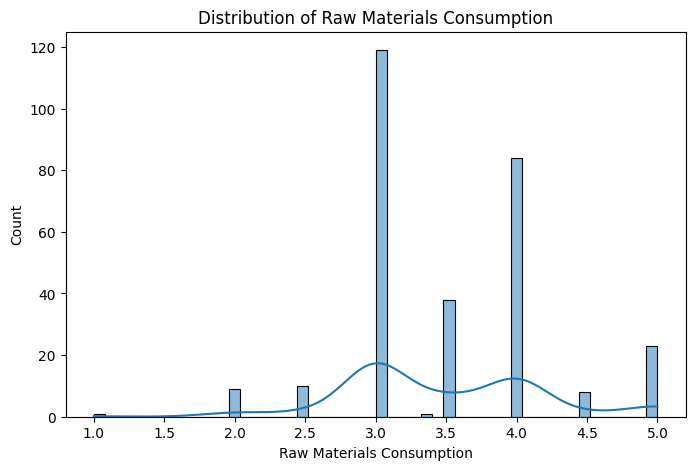

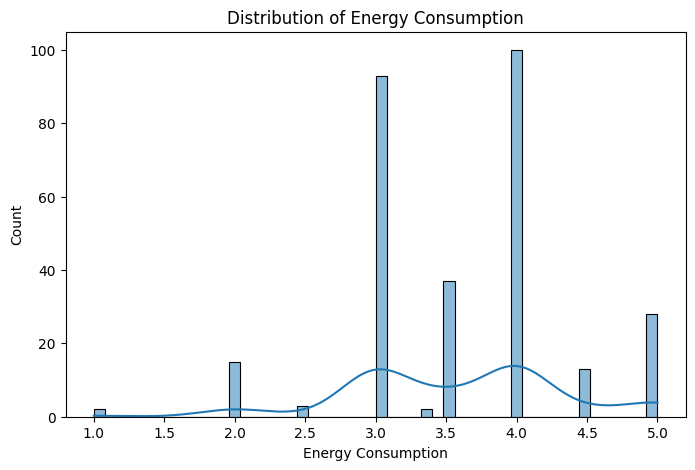

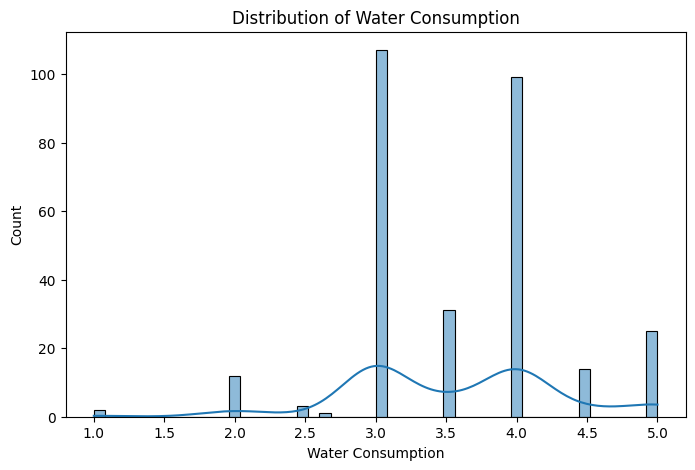

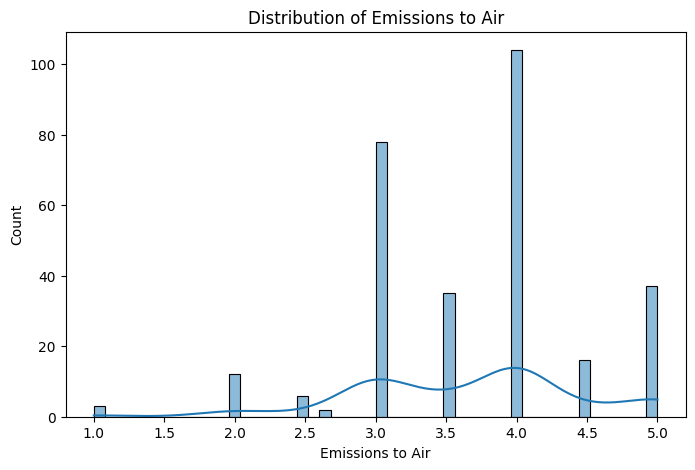

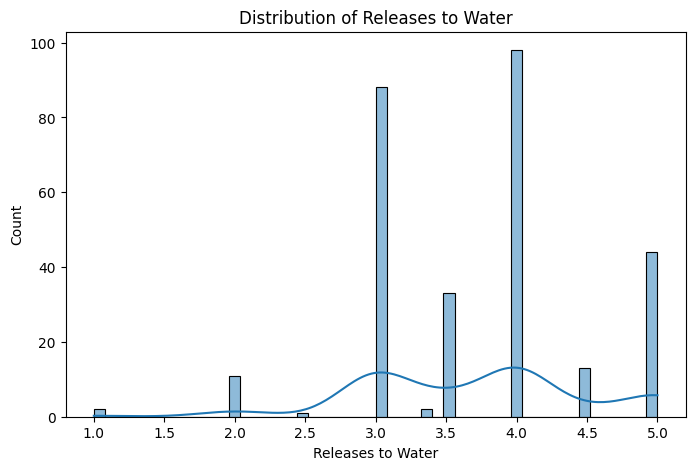

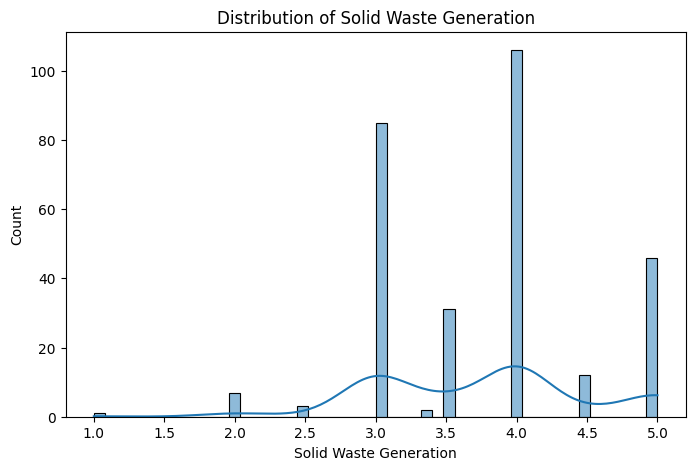

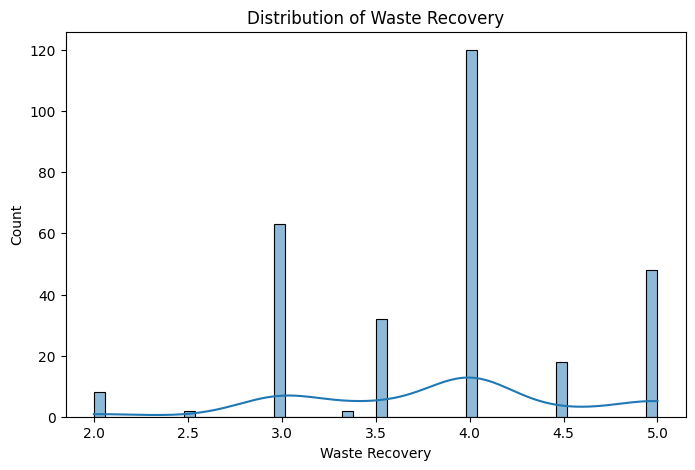

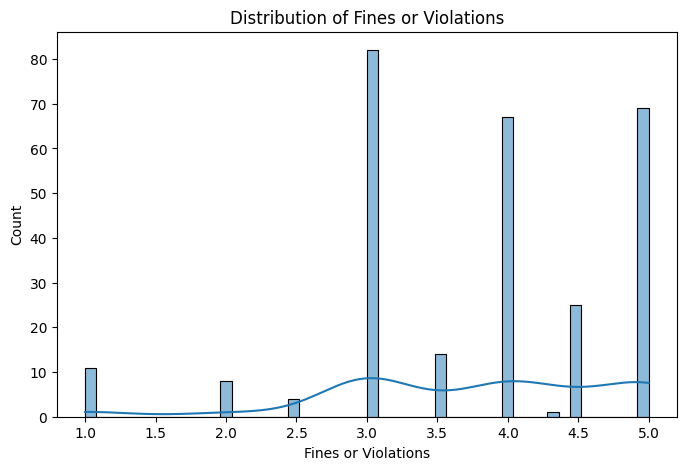

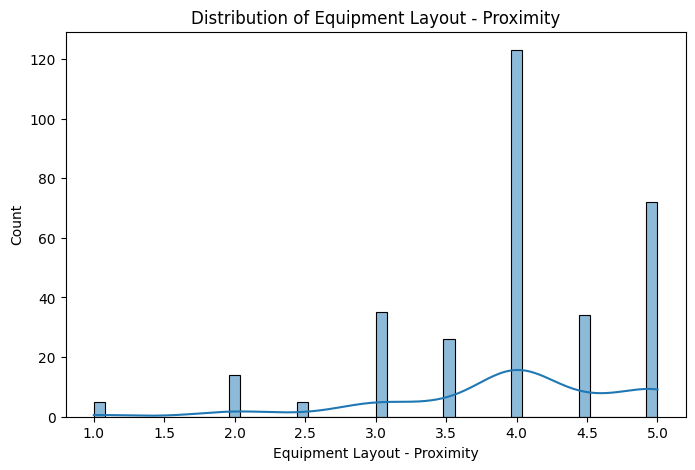

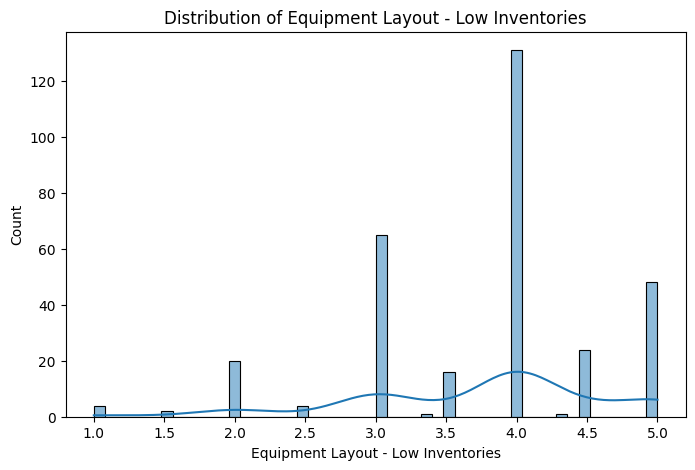

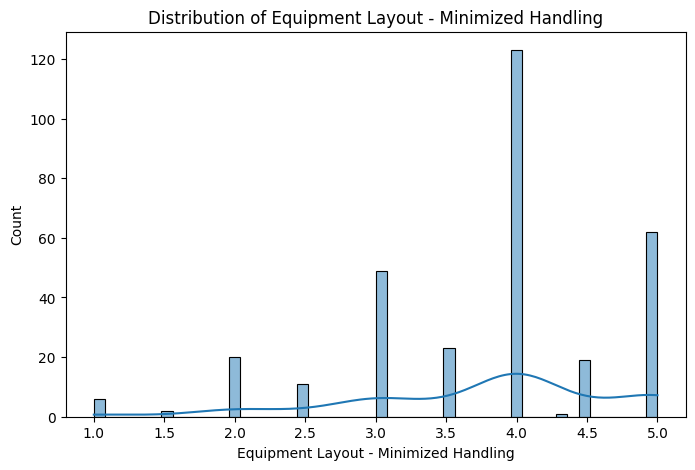

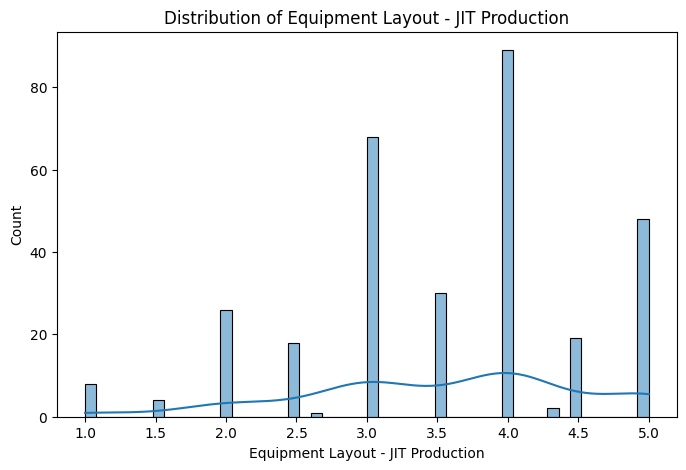

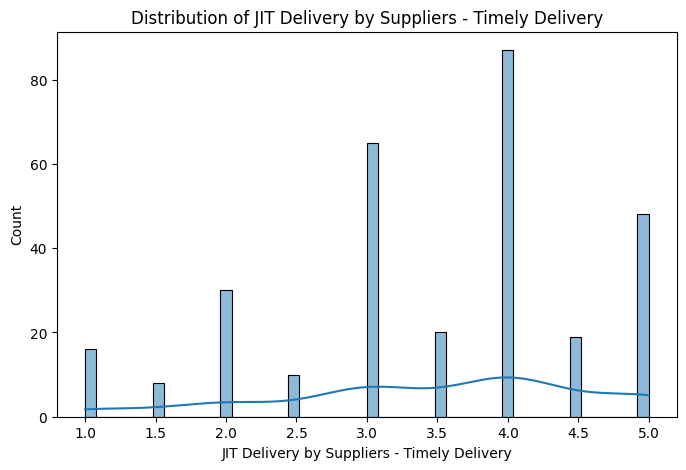

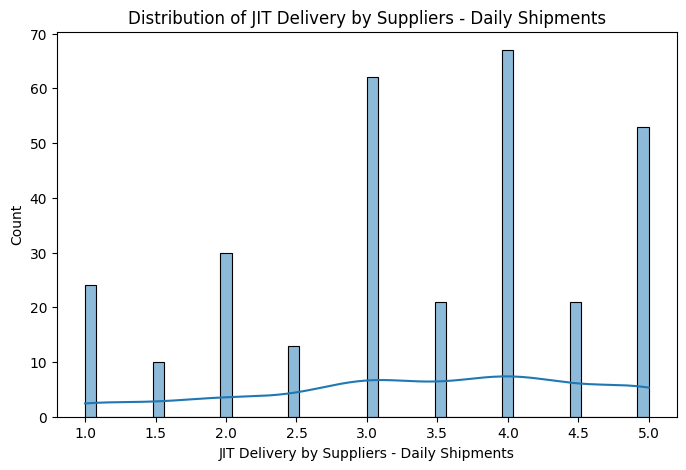

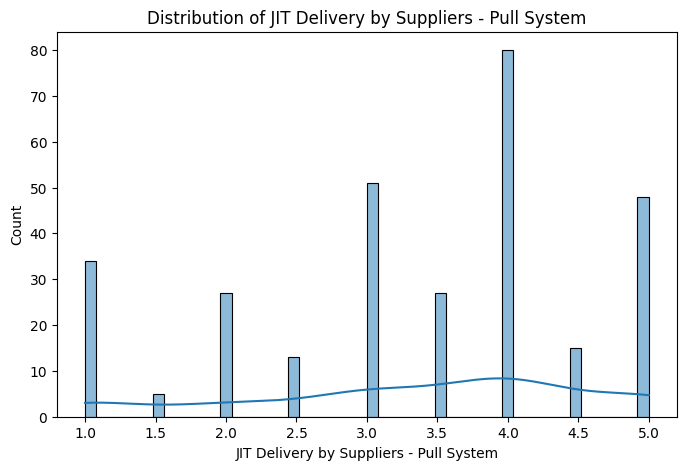

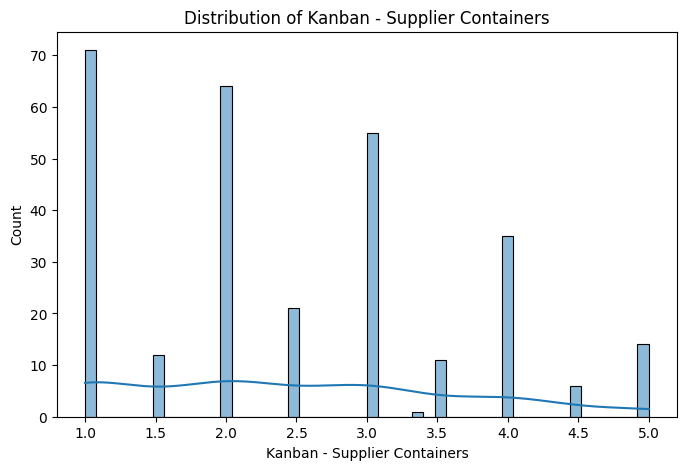

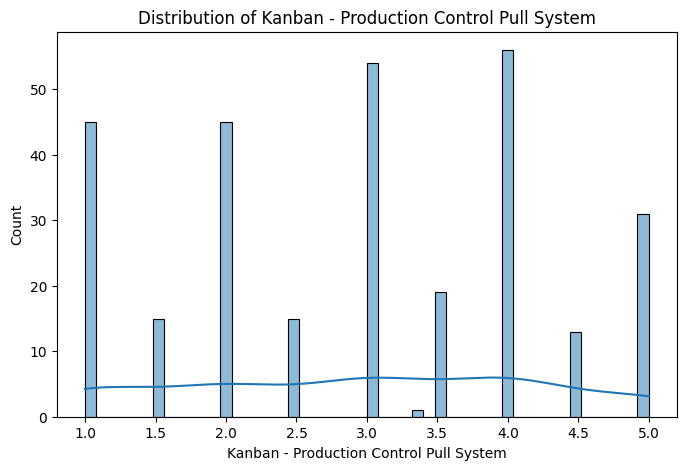

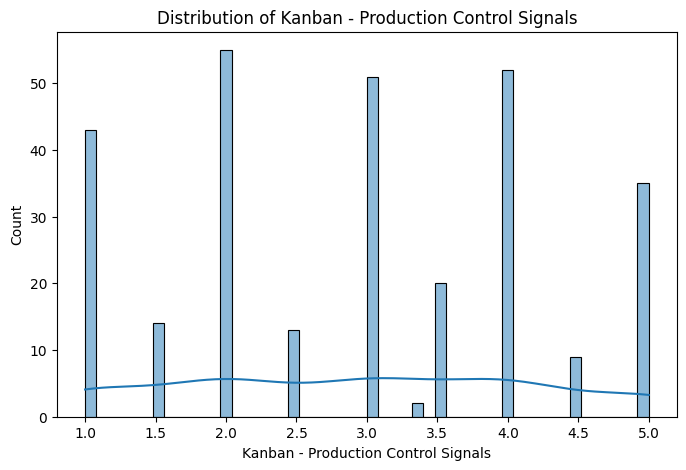

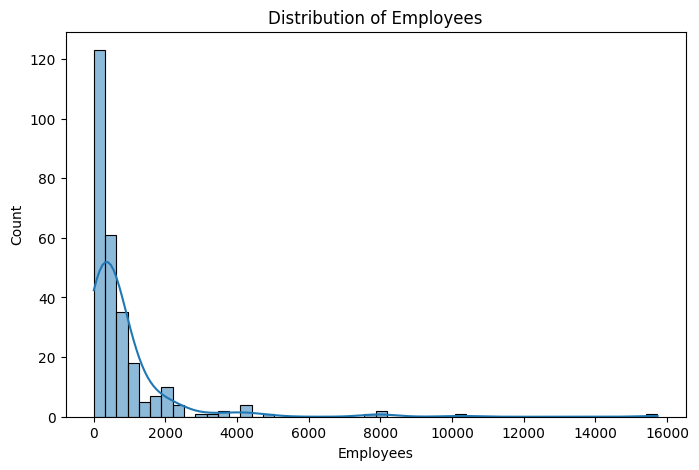

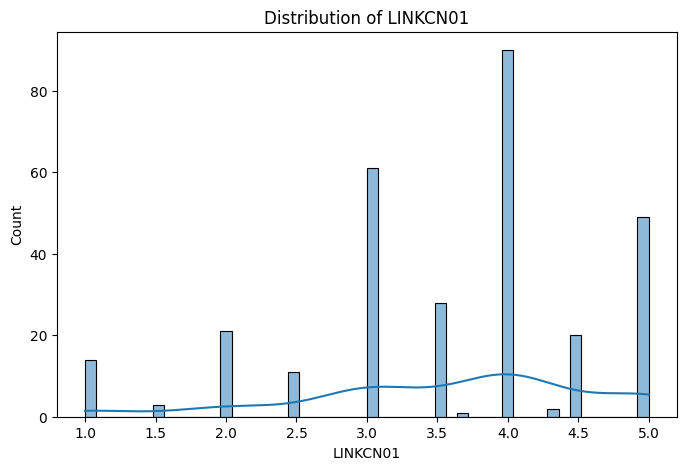

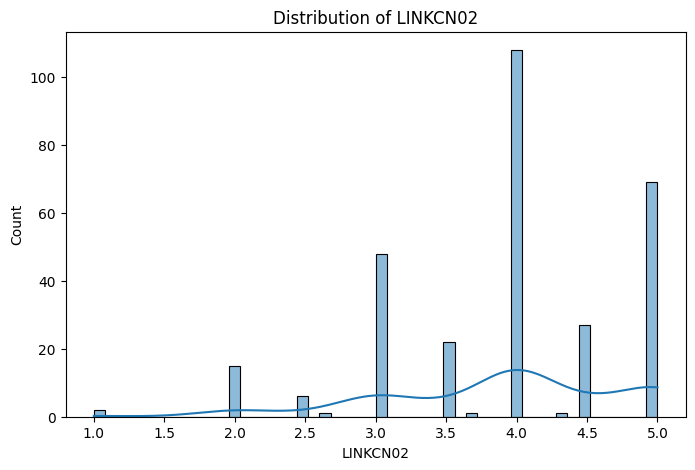

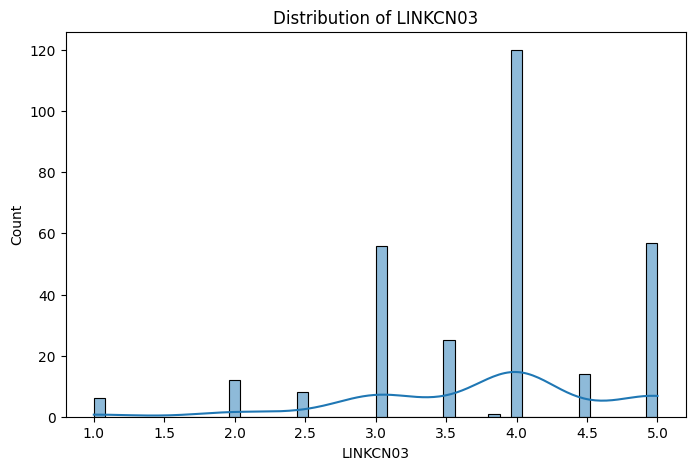

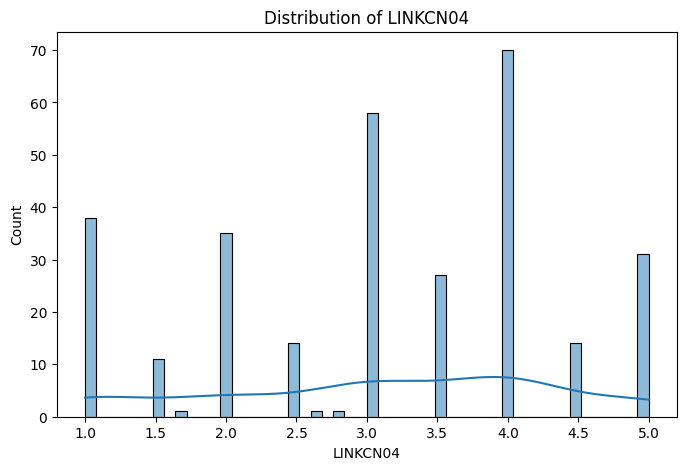

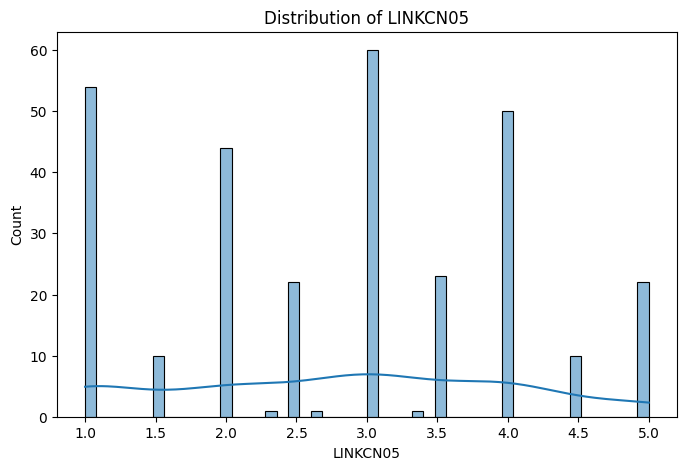

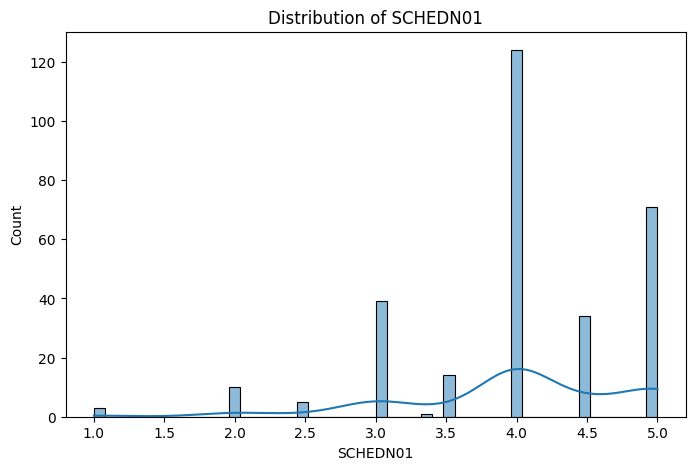

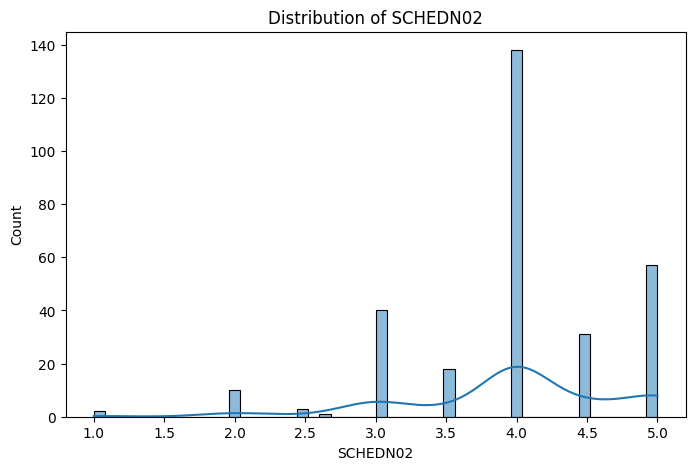

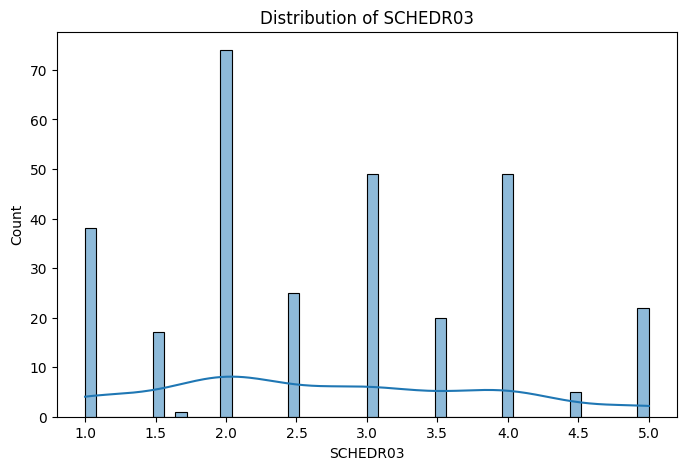

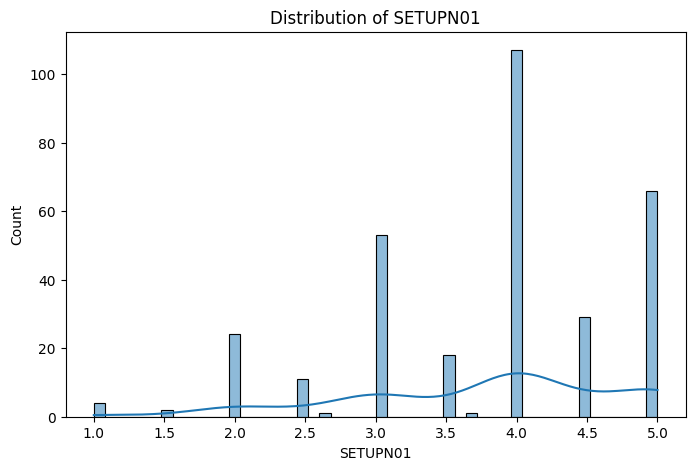

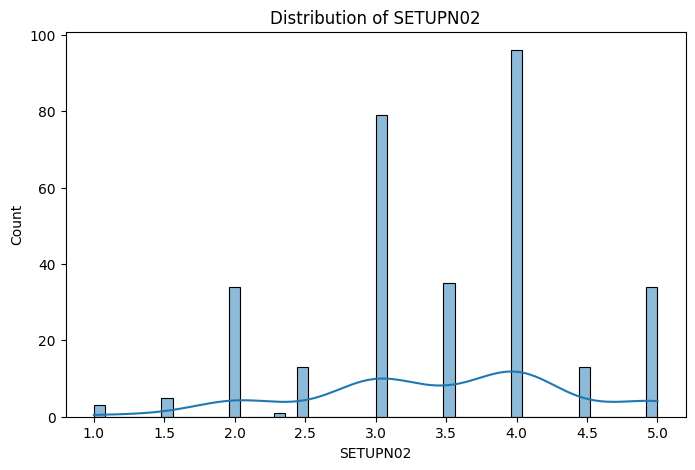

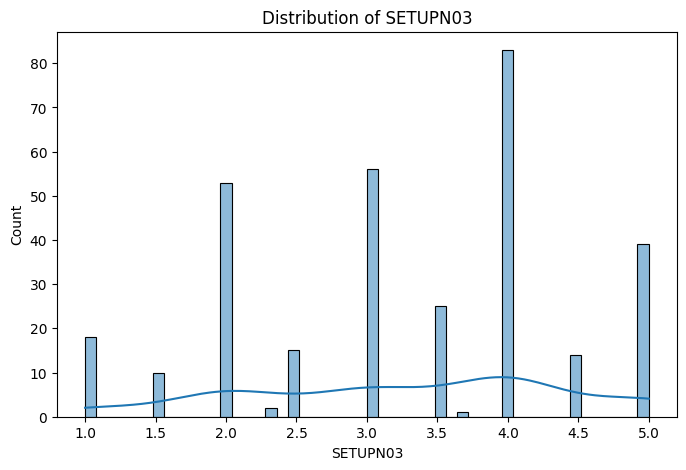

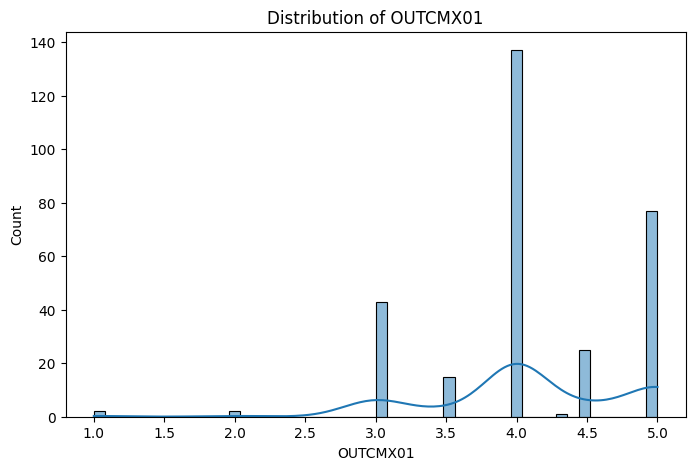

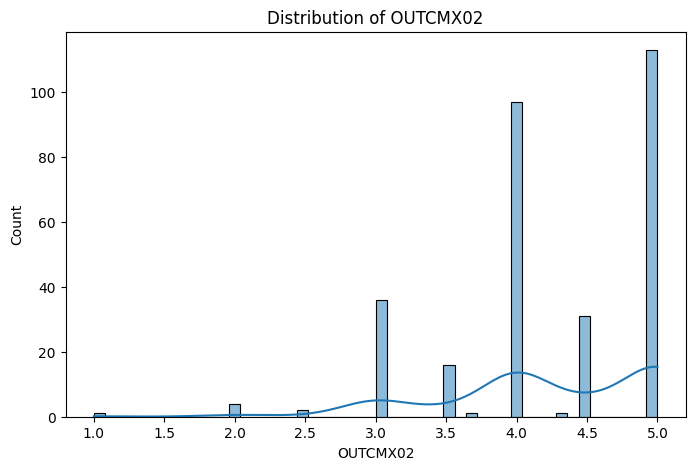

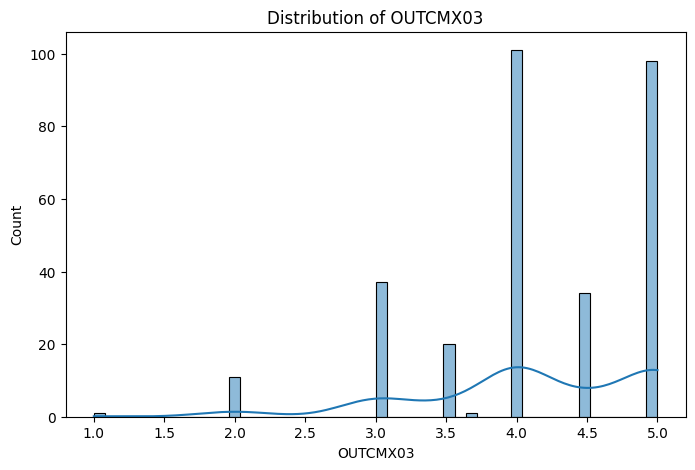

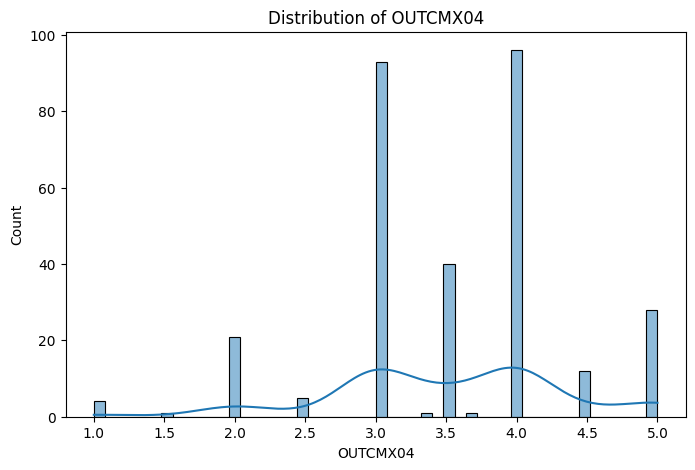

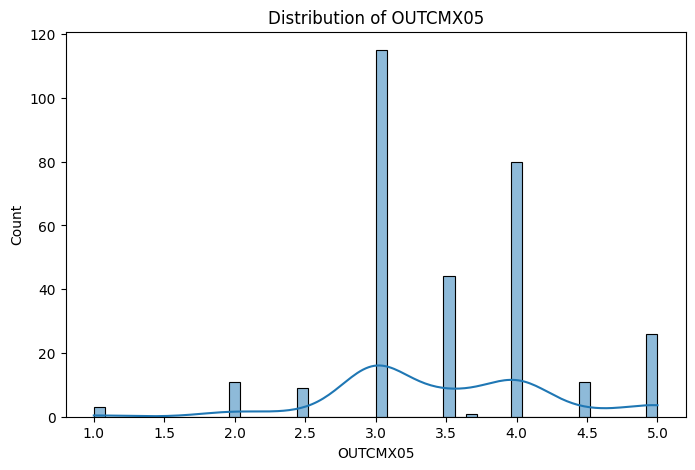

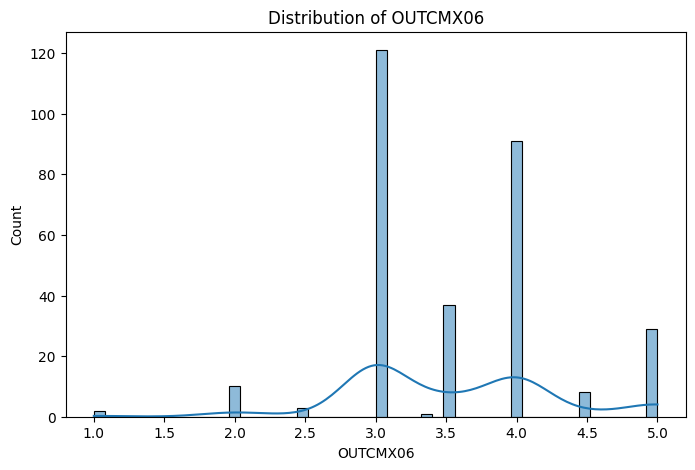

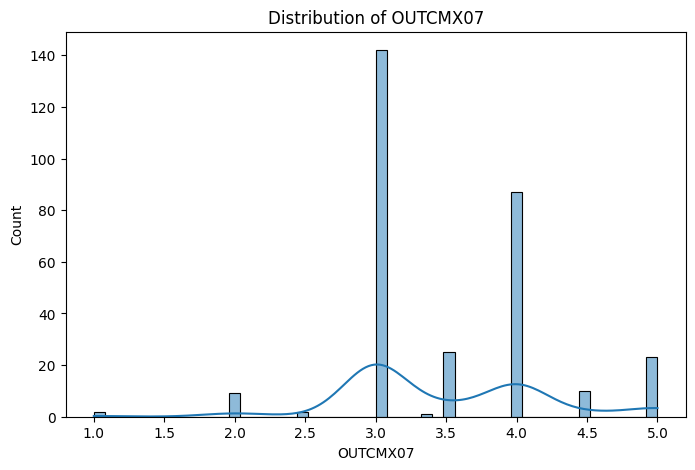

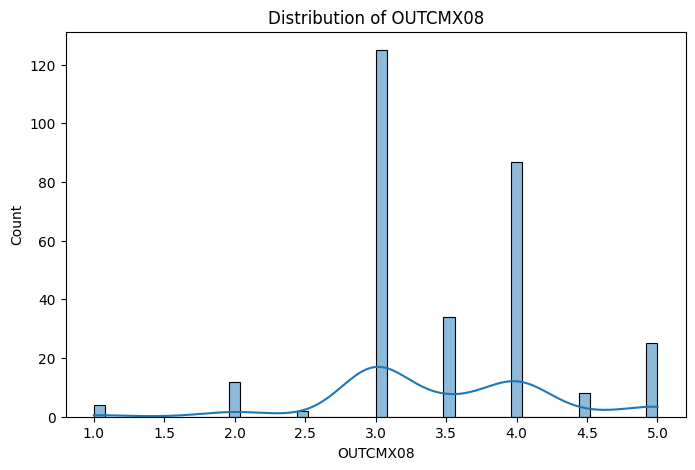

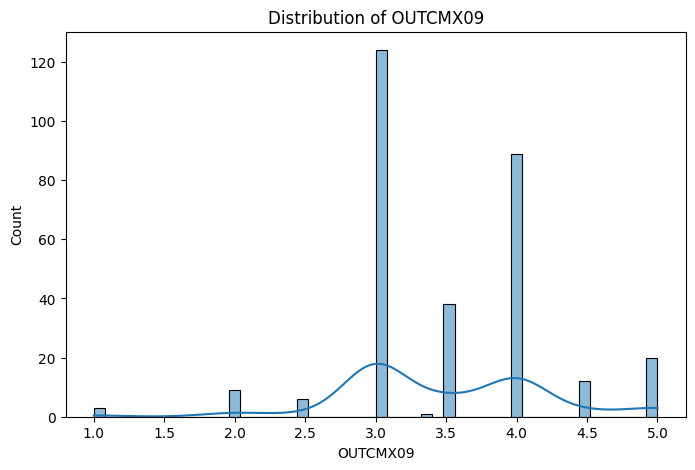

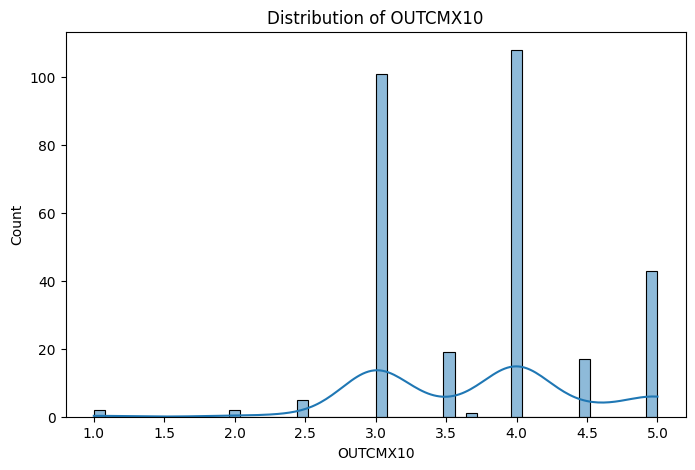

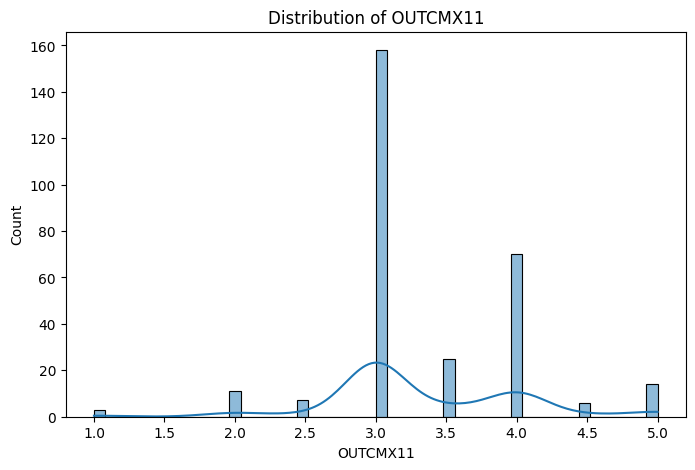

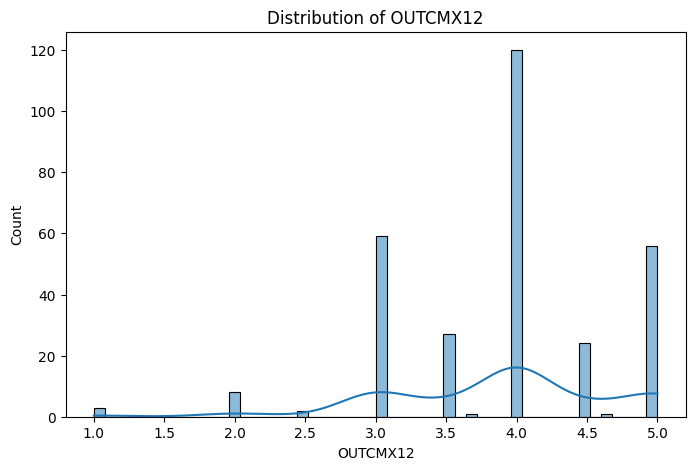

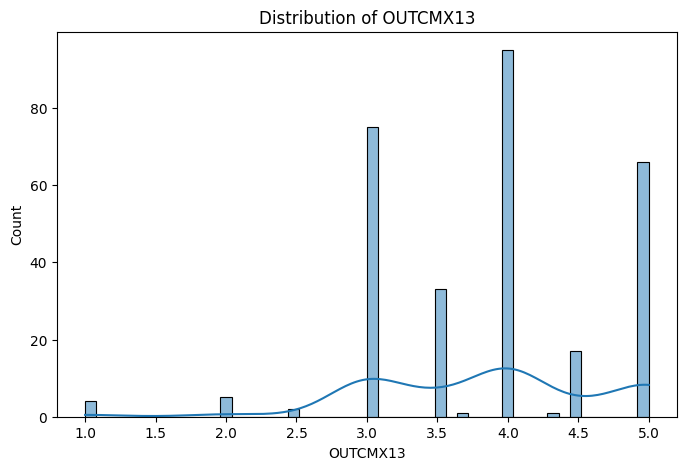

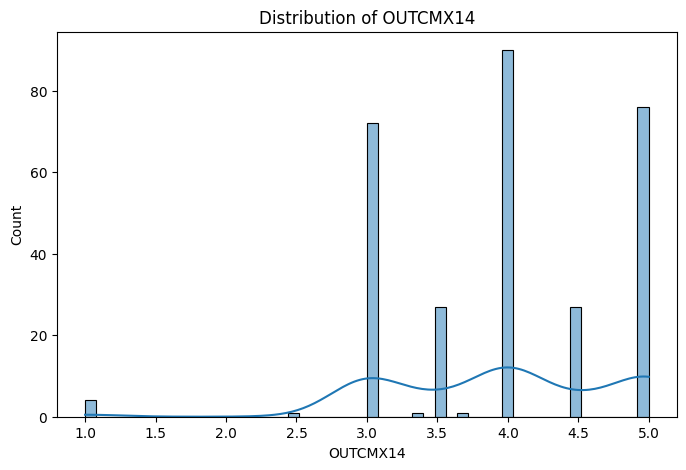

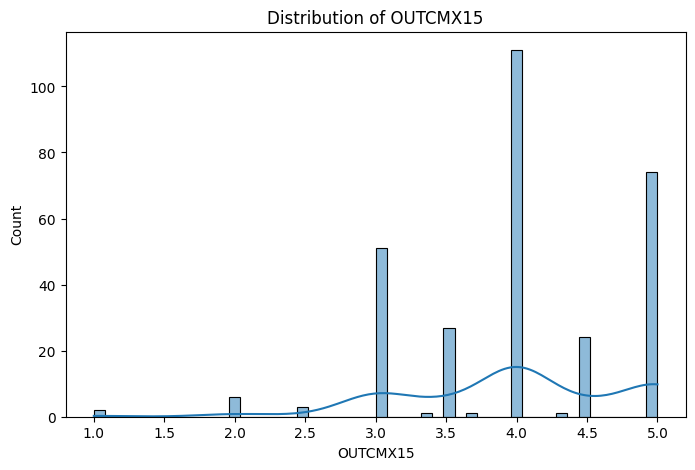

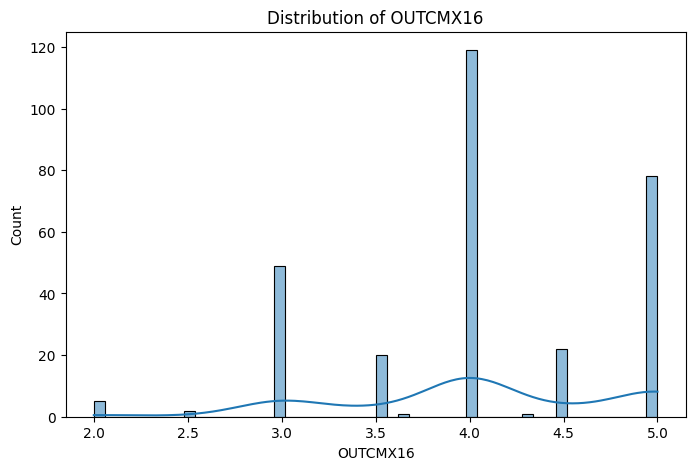

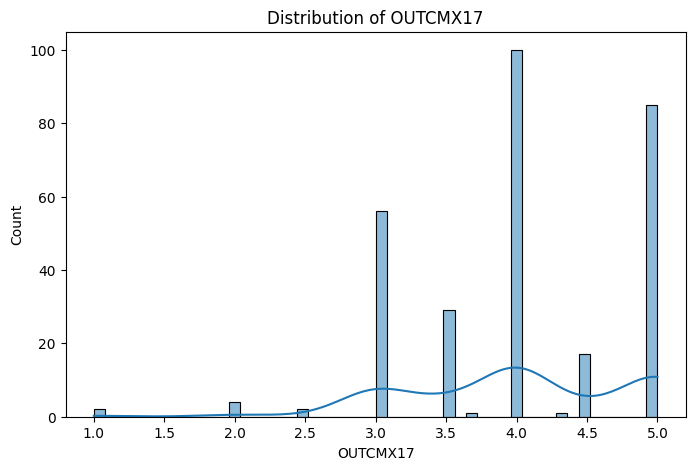

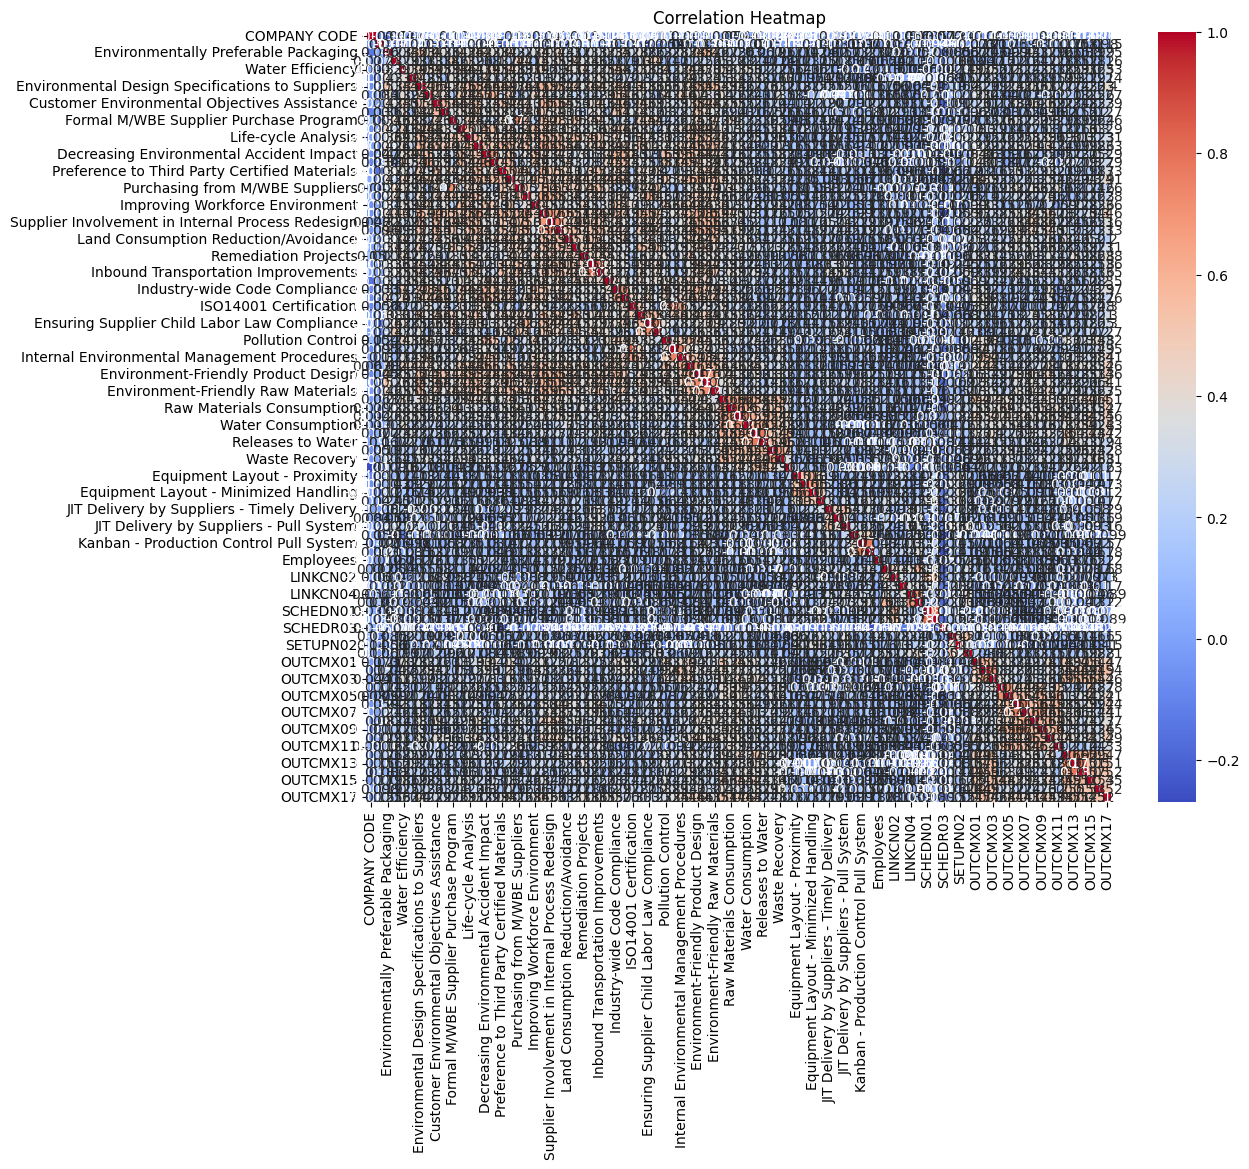


Normalized Data:

   COMPANY CODE  INDUSTRY  Environmentally Preferable Packaging  \
0      0.877193       1.0                                  0.75   
1      0.877741       0.0                                   NaN   
2      0.878289       0.0                                  0.50   
3      0.878838       1.0                                  0.25   
4      0.879386       1.0                                  0.25   

   Third Party Monitoring of Supplier Working Conditions  Water Efficiency  \
0                                               0.25                  0.75   
1                                                NaN                   NaN   
2                                               0.25                  0.50   
3                                               0.75                  0.25   
4                                               0.00                  0.50   

   Substituting Environmentally Preferable Direct Materials  \
0                                             

In [4]:
# Visualize the distribution of numerical variables
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()

for feature in numerical_features:
    plt.figure(figsize=(8,5))
    sns.histplot(data[feature], bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(12,10))
sns.heatmap(data[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Normalization (if needed)
# Here, we'll use Min-Max normalization as an example
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data[numerical_features]), columns=numerical_features)

# Check normalized data
print("\nNormalized Data:\n")
print(data_normalized.head())


## Confirmatory Factor Analysis

### Environmental x Lean JIT
Exploring CFA for bundles as per paper on complimentarity 

In [5]:
# Drop rows with missing values (or you can choose other imputation methods)
df_cleaned = data.dropna(subset=[
    'Environmentally Preferable Packaging', 
    'Third Party Monitoring of Supplier Working Conditions',
    'Water Efficiency', 
    'Substituting Environmentally Preferable Direct Materials',
    'JIT Delivery by Suppliers - Timely Delivery',
    'JIT Delivery by Suppliers - Daily Shipments', 
    'JIT Delivery by Suppliers - Pull System',
    'Kanban - Supplier Containers', 
    'Kanban - Production Control Pull System',
    'Kanban - Production Control Signals'
])

numeric_cols = df_cleaned.select_dtypes(include=[float, int]).columns
df_numeric = df_cleaned[numeric_cols]

# Model specification
model_dict = {
    "Environmental Practices": [
        'Environmentally Preferable Packaging', 
        'Third Party Monitoring of Supplier Working Conditions',
        'Water Efficiency', 
        'Substituting Environmentally Preferable Direct Materials'
    ],
    "Lean JIT Practices": [
        'JIT Delivery by Suppliers - Timely Delivery', 
        'JIT Delivery by Suppliers - Daily Shipments',
        'JIT Delivery by Suppliers - Pull System', 
        'Kanban - Supplier Containers',
        'Kanban - Production Control Pull System', 
        'Kanban - Production Control Signals']
}

# Extract all column names from the model_dict
desired_columns = [col for sublist in model_dict.values() for col in sublist]

# Filter df_numeric to include only those columns
df_numeric_filtered = df_numeric[desired_columns]

# Ensure model_dict keys and values are within numeric_cols
filtered_model_dict = {k: [col for col in v if col in numeric_cols] for k, v in model_dict.items() if all(col in numeric_cols for col in v)}

### Fit CFA model and get loadings, SE and t-values 

In [6]:
# Adjusted model specification
model_spec = ModelSpecificationParser.parse_model_specification_from_dict(df_numeric_filtered, filtered_model_dict)

# CFA model
cfa = ConfirmatoryFactorAnalyzer(model_spec)
cfa.fit(df_numeric_filtered)

# Extract the factor loadings
loadings = cfa.loadings_

# Get the standard errors for loadings and intercepts
se_all = cfa.get_standard_errors()

# Extract standard errors for loadings
se_loadings = se_all[0]

# Compute t-values
t_values = loadings / se_loadings

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94902D+03    |proj g|=  2.96146D+02

At iterate    1    f=  3.73451D+03    |proj g|=  5.74887D+01

At iterate    2    f=  3.71339D+03    |proj g|=  4.18710D+01

At iterate    3    f=  3.67642D+03    |proj g|=  1.82334D+01

At iterate    4    f=  3.67060D+03    |proj g|=  1.45133D+01

At iterate    5    f=  3.66629D+03    |proj g|=  1.36313D+01

At iterate    6    f=  3.66224D+03    |proj g|=  2.98429D+01

At iterate    7    f=  3.65815D+03    |proj g|=  1.38360D+01

At iterate    8    f=  3.65638D+03    |proj g|=  4.76248D+00

At iterate    9    f=  3.65618D+03    |proj g|=  5.38530D+00

At iterate   10    f=  3.65607D+03    |proj g|=  1.82190D+00

At iterate   11    f=  3.65604D+03    |proj g|=  1.25174D+00

At iterate   12    f=  3.65603D+03    |proj g|=  1.35542D+00

At iterate   13    f=  3.6

 This problem is unconstrained.



At iterate   19    f=  3.65602D+03    |proj g|=  3.86535D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     19     21      1     0     0   3.865D-03   3.656D+03
  F =   3656.0230843317267     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/var/folders/l3/xnhphxjs6_x60z1z798fy0dw0000gq/T/ipykernel_78639/1503887432.py:18: RuntimeWarning: invalid value encountered in divide
  t_values = loadings / se_loadings


### Generate dataframe which describes the CFA results 

In [7]:
data = {
    'Bundle': [],
    'Item description': [],
    'Loading': [],
    'SE': [],
    't-value': []
}

# Loop through each factor and then each item within that factor
for factor, items in model_dict.items():
    for item in items:
        item_idx = df_numeric_filtered.columns.get_loc(item)
        factor_idx = list(model_dict.keys()).index(factor)

        loading_value = loadings[item_idx][factor_idx]
        se_value = se_loadings[item_idx][factor_idx]
        t_value = t_values[item_idx][factor_idx]

        data['Bundle'].append(factor)
        data['Item description'].append(item)  # Using column names as descriptions for now
        data['Loading'].append(loading_value)
        data['SE'].append(se_value)
        data['t-value'].append(t_value)

# Convert the data to a DataFrame
results_df = pd.DataFrame(data)
print(results_df)


                    Bundle                                   Item description  \
0  Environmental Practices               Environmentally Preferable Packaging   
1  Environmental Practices  Third Party Monitoring of Supplier Working Con...   
2  Environmental Practices                                   Water Efficiency   
3  Environmental Practices  Substituting Environmentally Preferable Direct...   
4       Lean JIT Practices        JIT Delivery by Suppliers - Timely Delivery   
5       Lean JIT Practices        JIT Delivery by Suppliers - Daily Shipments   
6       Lean JIT Practices            JIT Delivery by Suppliers - Pull System   
7       Lean JIT Practices                       Kanban - Supplier Containers   
8       Lean JIT Practices            Kanban - Production Control Pull System   
9       Lean JIT Practices                Kanban - Production Control Signals   

    Loading        SE    t-value  
0  0.446066  0.059649   7.478169  
1  0.545700  0.082740   6.595395  
2  

#### Save CFA results to CSV

In [8]:
# To save the results to a CSV file
results_df.to_csv(OUTPUT_PATH + '/cfa_results.csv', index=False)

#### Compute P values for each t-value 

In [9]:
# Compute p-values from t-values
p_values = [2 * (1 - norm.cdf(abs(t))) for t in data['t-value']]  # Two-tailed test

# Add p-values to the results dataframe
results_df['p-value'] = p_values

results_df

Bundle                                   Item description  \
0  Environmental Practices               Environmentally Preferable Packaging   
1  Environmental Practices  Third Party Monitoring of Supplier Working Con...   
2  Environmental Practices                                   Water Efficiency   
3  Environmental Practices  Substituting Environmentally Preferable Direct...   
4       Lean JIT Practices        JIT Delivery by Suppliers - Timely Delivery   
5       Lean JIT Practices        JIT Delivery by Suppliers - Daily Shipments   
6       Lean JIT Practices            JIT Delivery by Suppliers - Pull System   
7       Lean JIT Practices                       Kanban - Supplier Containers   
8       Lean JIT Practices            Kanban - Production Control Pull System   
9       Lean JIT Practices                Kanban - Production Control Signals   

    Loading        SE    t-value       p-value  
0  0.446066  0.059649   7.478169  7.527312e-14  
1  0.545700  0.082740   6.595395  4.241252e-11  
2  0.513004  0.065647   7.814607  5.551115e-15  
3  0.678697  0.075372   9.004656  0.000000e+00  
4  0.510954  0.071124   7.184001  6.770140e-13  
5  0.291274  0.079538   3.662096  2.501600e-04  
6  0.438889  0.078424   5.596388  2.188640e-08  
7  0.614308  0.073298   8.381001  0.000000e+00  
8  1.043410  0.070629  14.773014  0.000000e+00  
9  1.095246  0.069277  15.809631  0.000000e+00

In [10]:
significant_results = results_df[results_df['p-value'] < 0.01]
significant_results

Bundle                                   Item description  \
0  Environmental Practices               Environmentally Preferable Packaging   
1  Environmental Practices  Third Party Monitoring of Supplier Working Con...   
2  Environmental Practices                                   Water Efficiency   
3  Environmental Practices  Substituting Environmentally Preferable Direct...   
4       Lean JIT Practices        JIT Delivery by Suppliers - Timely Delivery   
5       Lean JIT Practices        JIT Delivery by Suppliers - Daily Shipments   
6       Lean JIT Practices            JIT Delivery by Suppliers - Pull System   
7       Lean JIT Practices                       Kanban - Supplier Containers   
8       Lean JIT Practices            Kanban - Production Control Pull System   
9       Lean JIT Practices                Kanban - Production Control Signals   

    Loading        SE    t-value       p-value  
0  0.446066  0.059649   7.478169  7.527312e-14  
1  0.545700  0.082740   6.595395  4.241252e-11  
2  0.513004  0.065647   7.814607  5.551115e-15  
3  0.678697  0.075372   9.004656  0.000000e+00  
4  0.510954  0.071124   7.184001  6.770140e-13  
5  0.291274  0.079538   3.662096  2.501600e-04  
6  0.438889  0.078424   5.596388  2.188640e-08  
7  0.614308  0.073298   8.381001  0.000000e+00  
8  1.043410  0.070629  14.773014  0.000000e+00  
9  1.095246  0.069277  15.809631  0.000000e+00